# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import date
import datetime
import calendar
import random

In [2]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from keras.utils.np_utils import to_categorical

C:\Users\20175377\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\20175377\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# All the Definitions

In [3]:
def getdata (h_num):
    dates = [] #declaration of dict.
#get data from excel sheet (Folder:Master Data base)
    addr = 'C:/Users/20175377/OneDrive/SmartMeters/MasterDB/House{}.xlsx'.format(h_num)
    Mdb =  pd.read_excel(addr, error_bad_lines=False)
#Drop all unwanted coloumns and convert Unix time to Std. Time --> sort it by time
    H1 = Mdb.drop(['DataID','DeviceID','SellMin','SellMax','Gas','BuyMin','BuyMax','Pro'], axis = 1)
    H1 = H1.set_index(Mdb['uTime'].values)
    H1.iloc[:,0] = H1.iloc[:,0].astype("datetime64[s]") #convert unix time stamp to std. time stamp
    H1 = H1.sort_index()
#add coloumns for date, hrs, min and sec
    H1.loc[:,'D']  = [str(time)[0:10] for time in H1.iloc[:,0].values]
    H1.loc[:,'HH'] = [str(time)[11:13] for time in H1.iloc[:,0].values]
    H1.loc[:,'MM'] = [str(time)[14:16] for time in H1.iloc[:,0].values]
    H1.loc[:,'SS'] = [str(time)[17:19] for time in H1.iloc[:,0].values]
#find number of days in table
    dates = [str(time)[0:10] for time in H1.iloc[:,0].values] #get 10 char of time for each time values
    dates = sorted(list(set(dates))) #convert it to set to get unique values and convert back to list
#Group the data on time hrs mint ang get aggregated data of one min frequency
    dfg = H1.groupby(['D','HH','MM'])['Con'].mean()
    C_Mean = dfg.mean()
    C_min = dfg.min()
    C_max = dfg.max()
    C_std = dfg.std()
    gen_info = [C_Mean,C_min,C_max,C_std]
    matrix = get_matrix(dates,dfg)
# return the matrix of data arranged by dates coloumn wise, return the dates of data and the general info abt the data set
    return(dates,gen_info,matrix)


def get_matrix(dates,OneMin_data):
#now we want to have a matrix of order (no. of min in a day x no. of dates in table)
    dfg = OneMin_data
    fr = 60
    intervals = 24*fr
    a = np.empty([intervals,len(dates)])
    i = 0
    j = 0
    for day in (dates):
        dfd = dfg.loc[str(day)]
        for hrs in range(24):
            try:
                dfh = dfd.loc[str(hrs).zfill(2)]
            except:
                pass
            for mi in range(60):
                try:
                    dfs = dfh.loc[str(mi).zfill(2)]
                except:
                    dfs = 0
                    pass
                a[j][i] = dfs
                dfs = 0
                j = j+1
        j=0
        i= i+1
    return(a)
def getdataofHouse(houses):
    Matrix = {}
    Dates  = {}
    ind = houses
    col = ['Mean','Min','Max','Std.']
    info = pd.DataFrame(columns = col)#index = ind, 
    for h in (houses):
        dates,gen_info,matrix = getdata(h)
        key = h
        Dates[h]  = dates
        Matrix[h] = matrix
        info.loc['House{}'.format(h)] = gen_info
        print('House {0} data contain {1} days from {2} to {3}.'.format(h,len(dates),dates[0], dates[-1]))
        print(dates)
    display(info)
    return(Dates,Matrix,info)

def set_resolution(dates,mat,res):
    if res == 1:
        matrix = mat
    else:
        intervals = (24*60)//res
        matrix = np.empty([intervals,len(dates)])
        i =0
        for day in (dates):
            m = 0
            for j in range(intervals):
                matrix[j][i] = sum(mat[m:(m+res),i])
                m = m+res
            i = i+1
    return(matrix)

def visual_data(Dates,Matrices,agg,res):
#plot all the data date wise
    i=0
    for day in (Dates):
        fig, axes = plt.subplots(1,len(Matrices), figsize=(24, 5) )
        j=0
        for k in (keys):
            axes.flat[j].plot(set_resolution(Dates,Matrices[k],res)[:,i], alpha = 0.6)
            title = 'House:{0} :: Date:{1} :: {2}'.format(k,day, calendar.day_name[(datetime.datetime.strptime(day, '%Y-%m-%d')).weekday()])
            axes.flat[j].set_title(title, fontsize = '15')
            plt.ylabel('Consumption (W/min)')
            plt.xlabel('Time (min)')
            j = j+1
        plt.show()
        plt.figure(num=None, figsize=(18, 5), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(agg[:,i],)
        plt.ylabel('Consumption (W/min)')
        plt.xlabel('Time (min)')
        plt.suptitle('Aggregated Plot:{0} :: Date:{1} :: {2}'.format(i+1,day, calendar.day_name[(datetime.datetime.strptime(day, '%Y-%m-%d')).weekday()]), fontsize = '15')
        i = i+1

def aggregate (Matrices):
#Sum up all the house data and mean it
    agg = 0
    for key in (Matrices):
        agg = agg + Matrices[key]
    agg = agg/len(Matrices)
    return(agg)

def create_label_dataset (l1,l2,l3):
#Generate Random data set between 0 and level 1,level2 and level 3.
    a = np.empty([100000,3])
    for i in range(100000):
        a[i,0] = random.uniform(0,l1)
        a[i,1] = random.uniform(l1,l2)
        a[i,2] = random.uniform(l2,l3)
    return(a)

def label_data(matrix,l1,l2,l3):
#classify the data in 3 levels(l1 = Base load (<40% of peak), l2 = partially flexible(40 - 70 %), l3 = flexible (>70%))
    label = np.empty_like(matrix)
    for j in range(len(matrix[0])):
        for k in range(len(matrix)):
            if matrix[k][j] == 0:
                label[k][j] = 0
            elif matrix[k][j] <= l1:
                label[k][j] = 1
            elif (matrix[k][j] > l1 and matrix[k][j] <= l2):
                label[k][j] = 2
            else:
                label[k][j] = 3
    return(label)

def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Error on training data')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

### ---------------------------------------### Data Acquisition, cleaning and visualization begins ###---------------------------------

In [4]:
#Get all the data in matrix with resolution of 1 min
Dates,Matrices,info = getdataofHouse([10,13])
keys = list(Dates.keys())
Date = Dates[keys[1]]

House 10 data contain 19 days from 2018-10-08 to 2018-11-15.
['2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11', '2018-10-12', '2018-10-13', '2018-10-14', '2018-10-15', '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-20', '2018-11-09', '2018-11-10', '2018-11-11', '2018-11-12', '2018-11-13', '2018-11-14', '2018-11-15']
House 13 data contain 19 days from 2018-10-08 to 2018-11-15.
['2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11', '2018-10-12', '2018-10-13', '2018-10-14', '2018-10-15', '2018-10-17', '2018-10-18', '2018-10-19', '2018-10-20', '2018-11-09', '2018-11-10', '2018-11-11', '2018-11-12', '2018-11-13', '2018-11-14', '2018-11-15']


,Mean,Min,Max,Std.
House10,345.039734,54.090909,4216.375,428.274611
House13,496.801095,10.000000,4898.000,711.848115


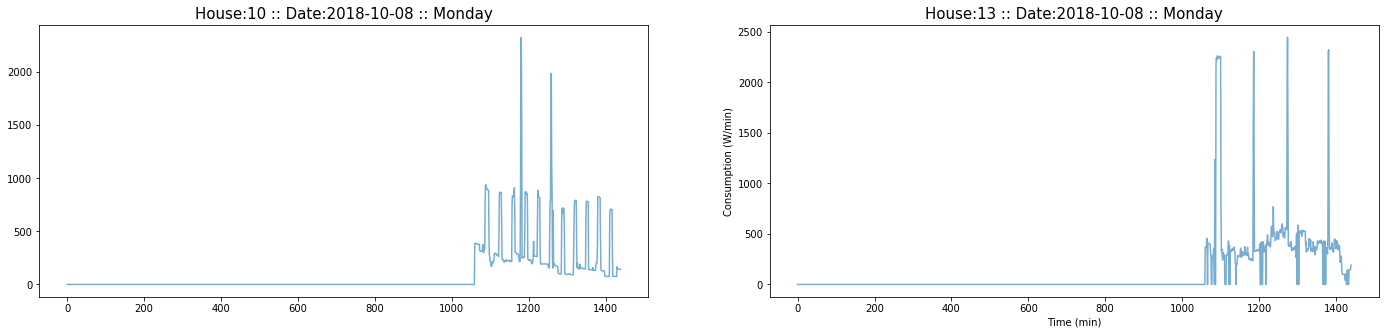

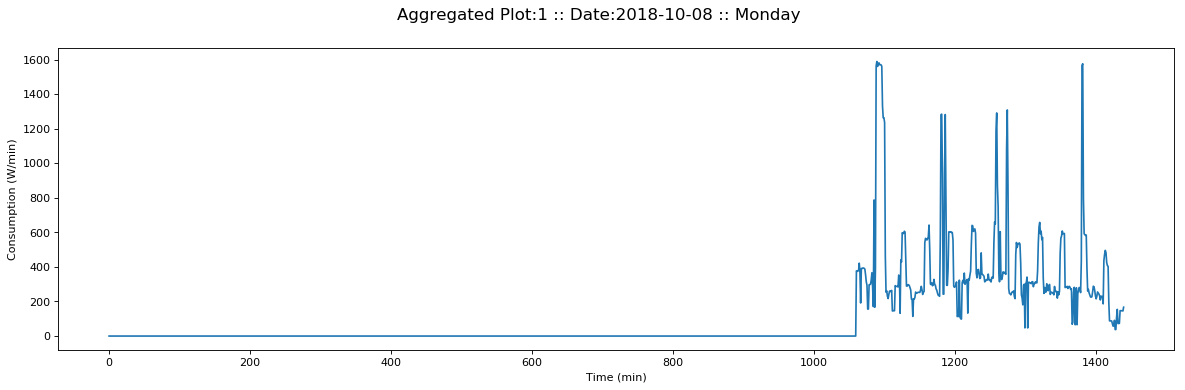

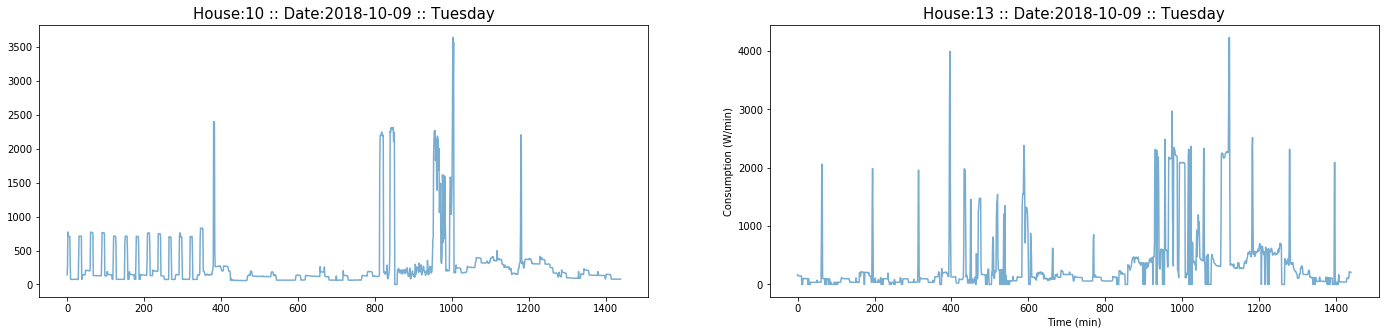

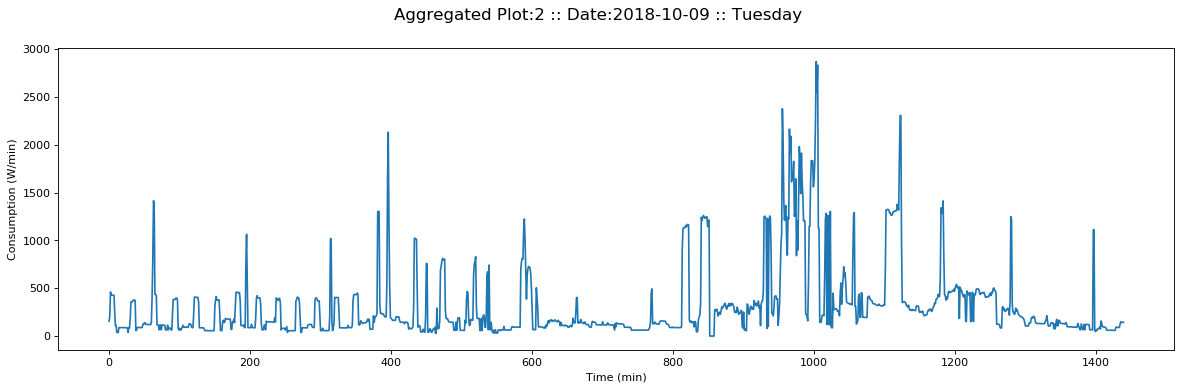

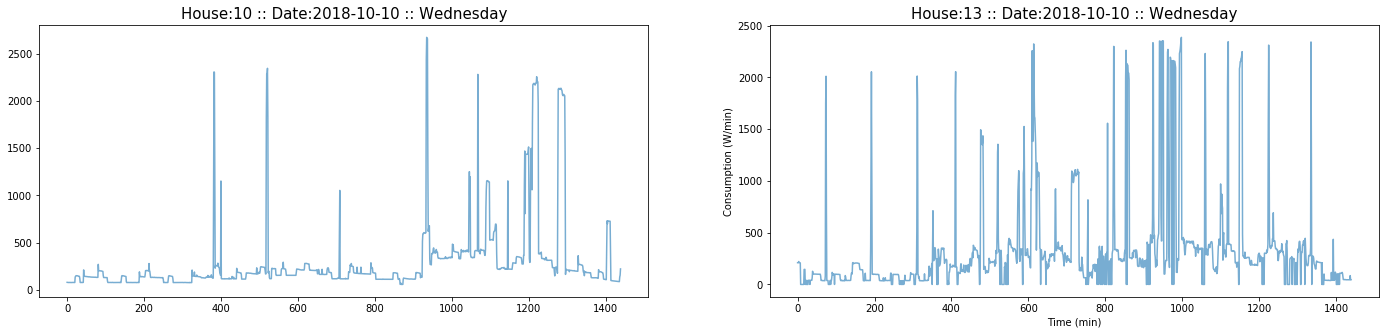

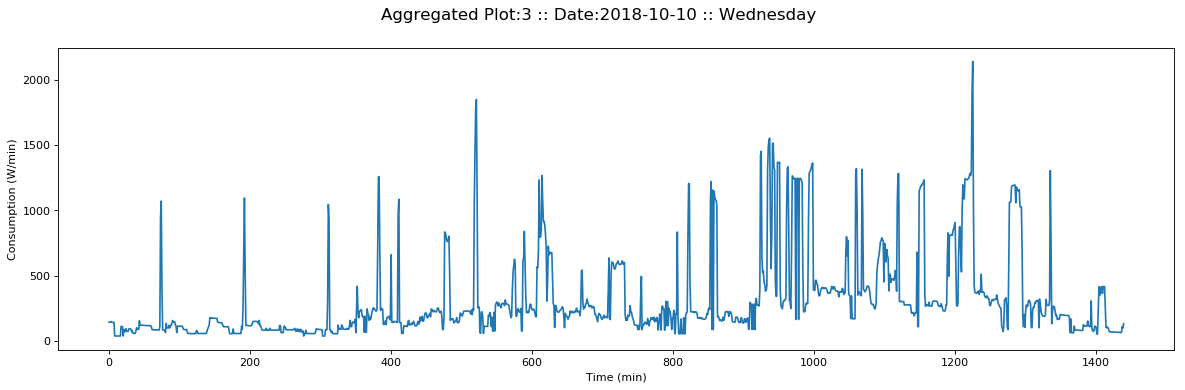

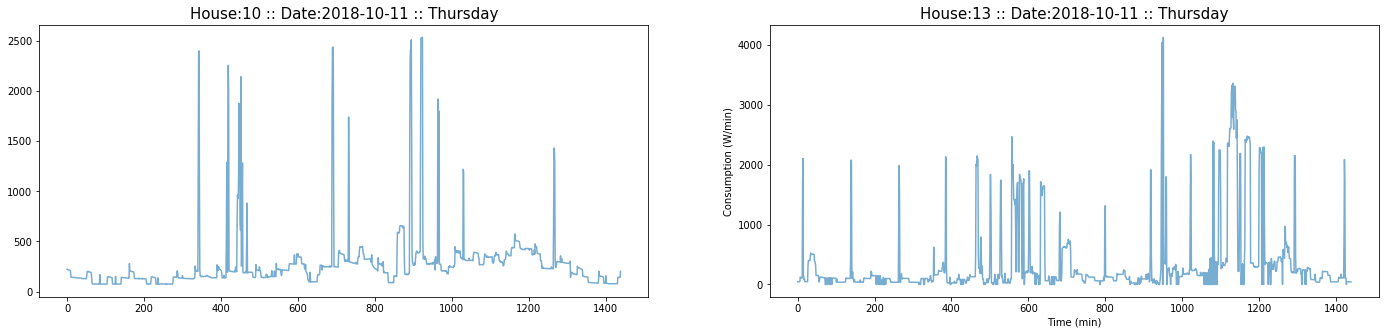

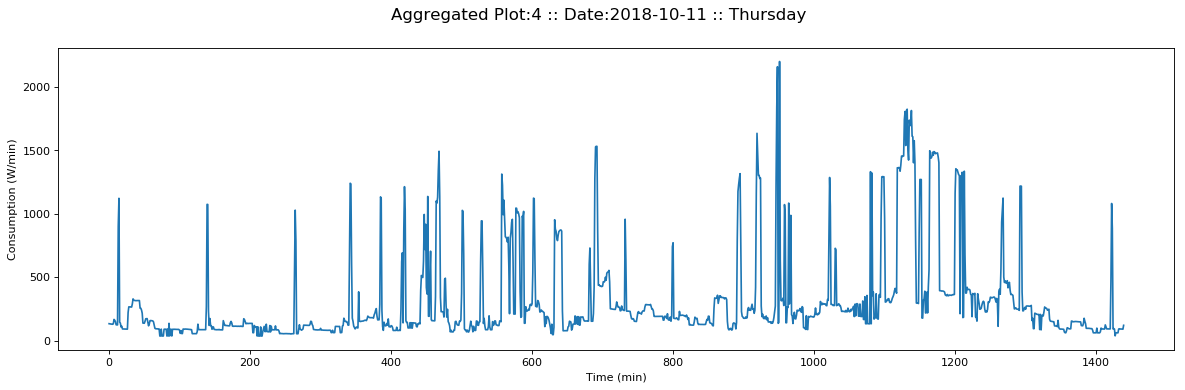

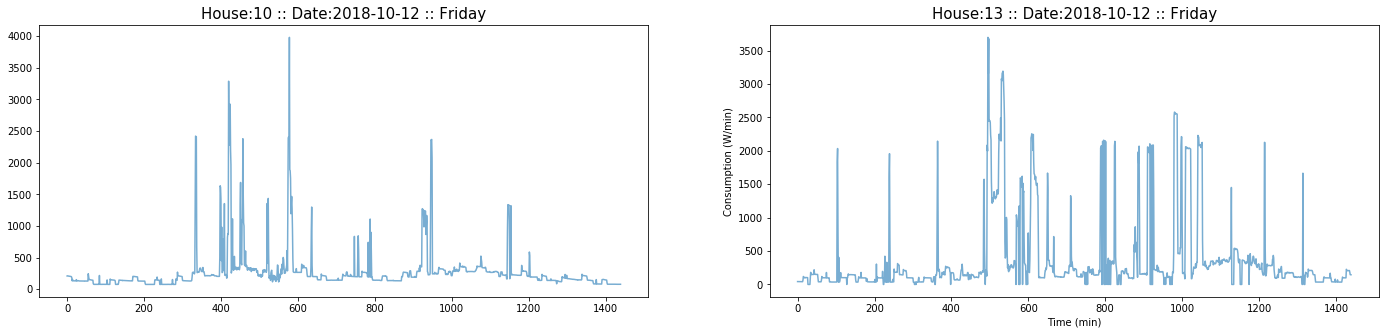

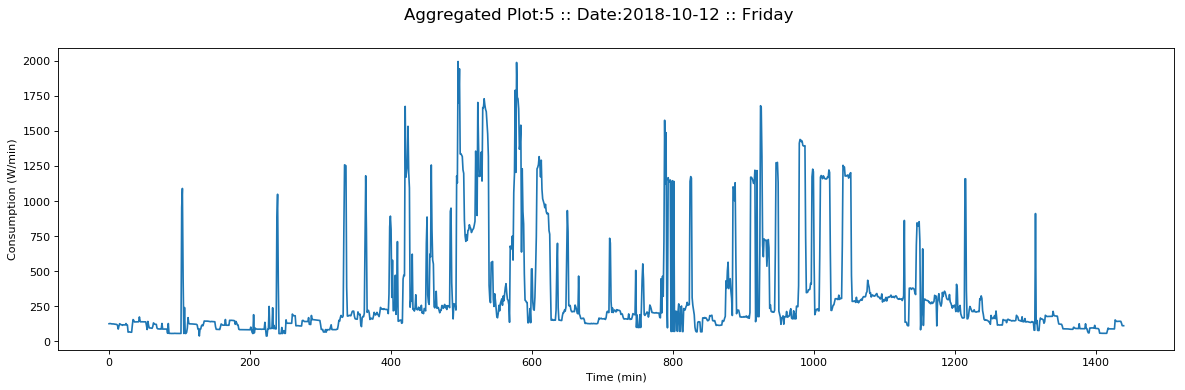

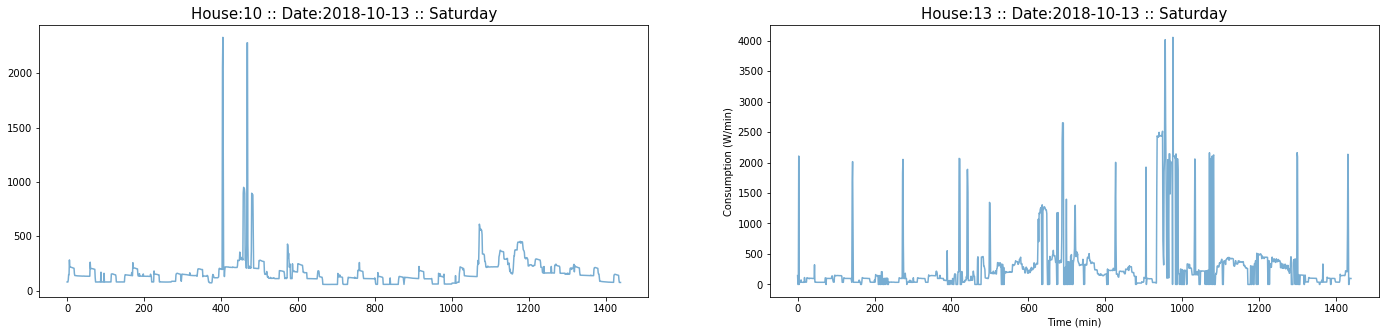

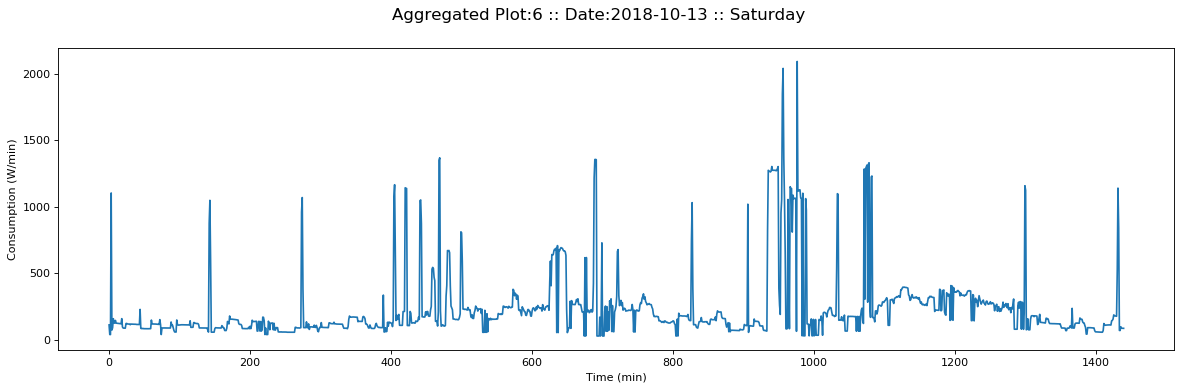

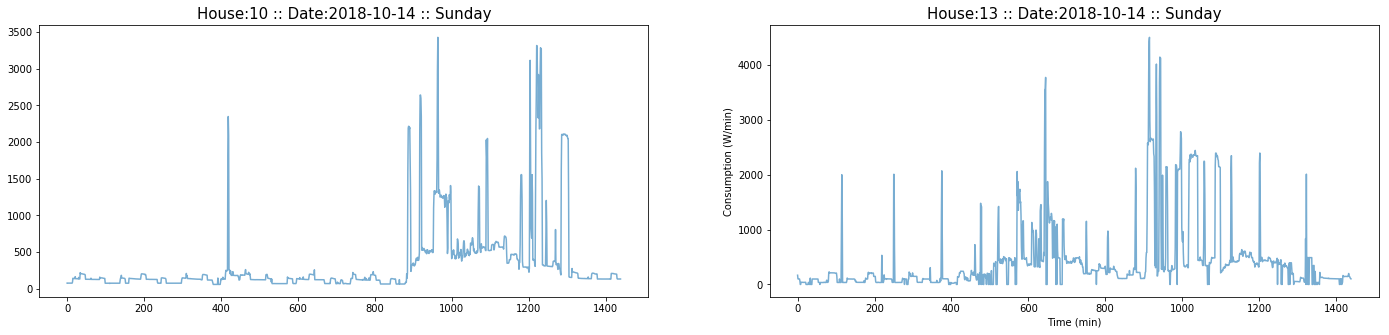

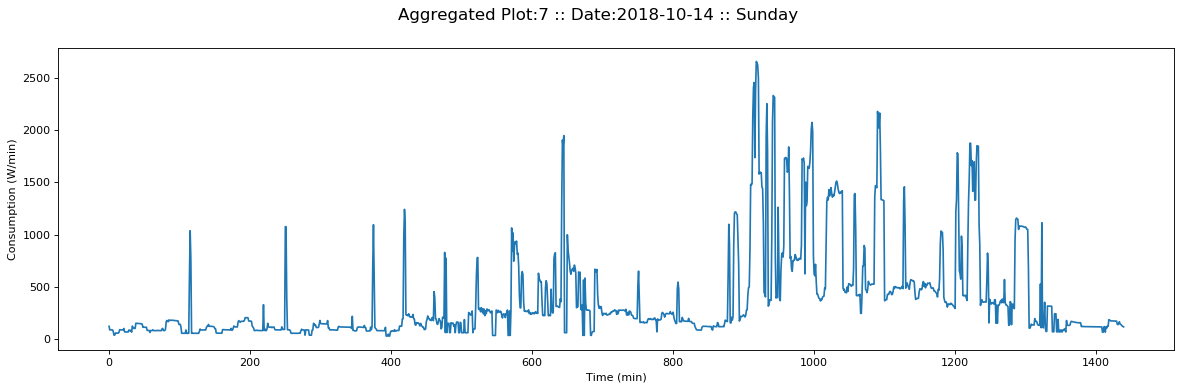

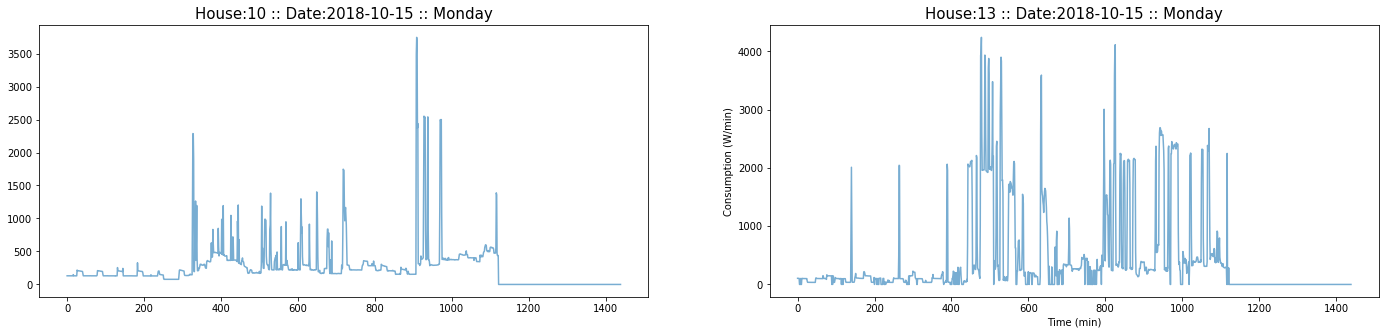

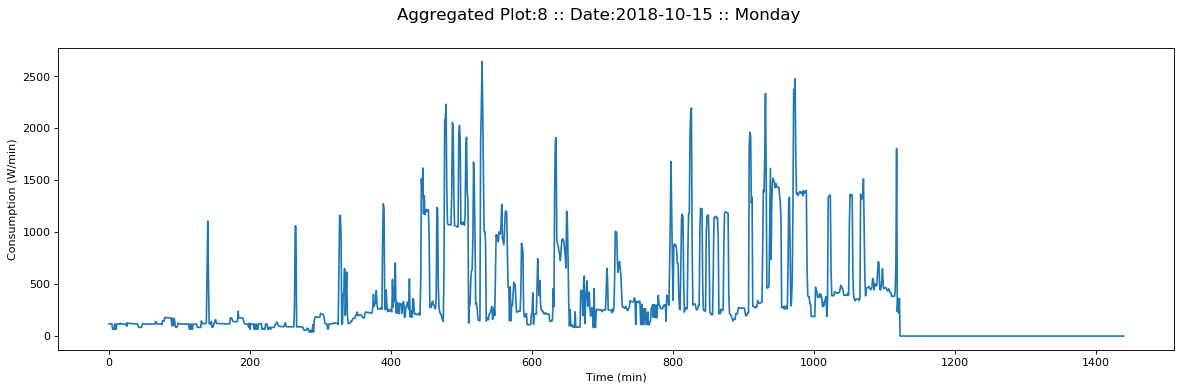

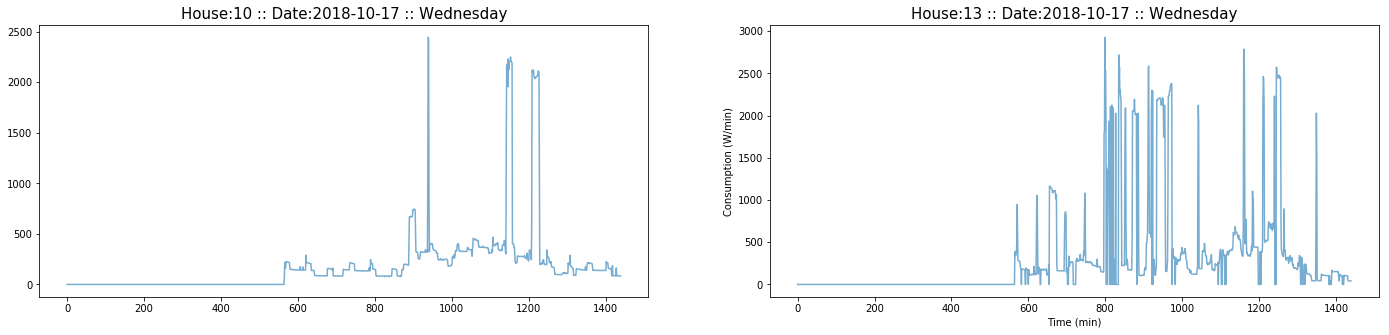

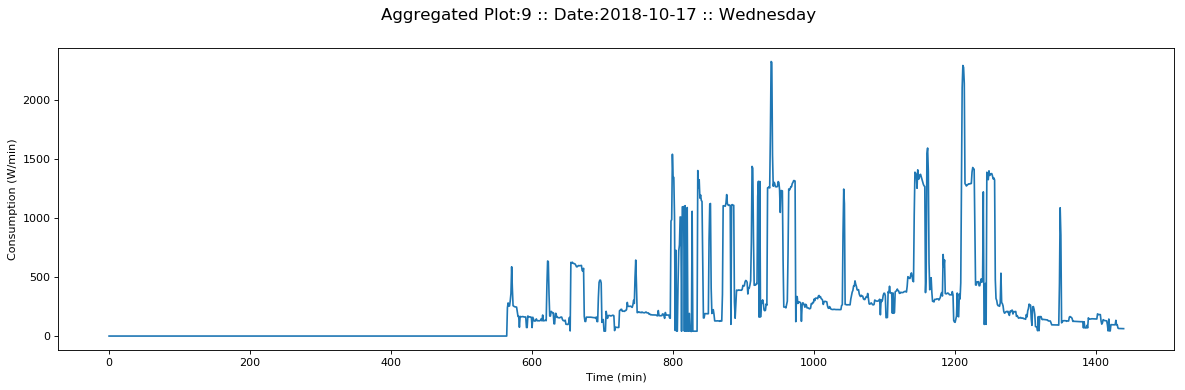

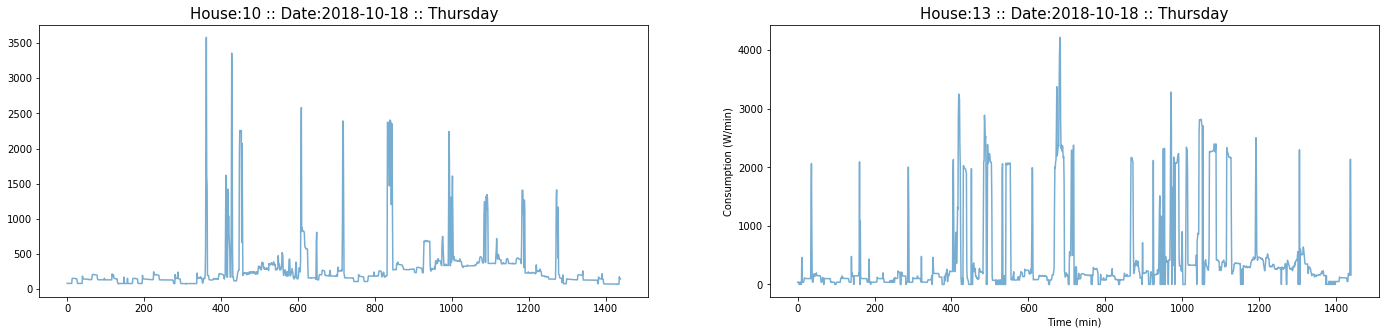

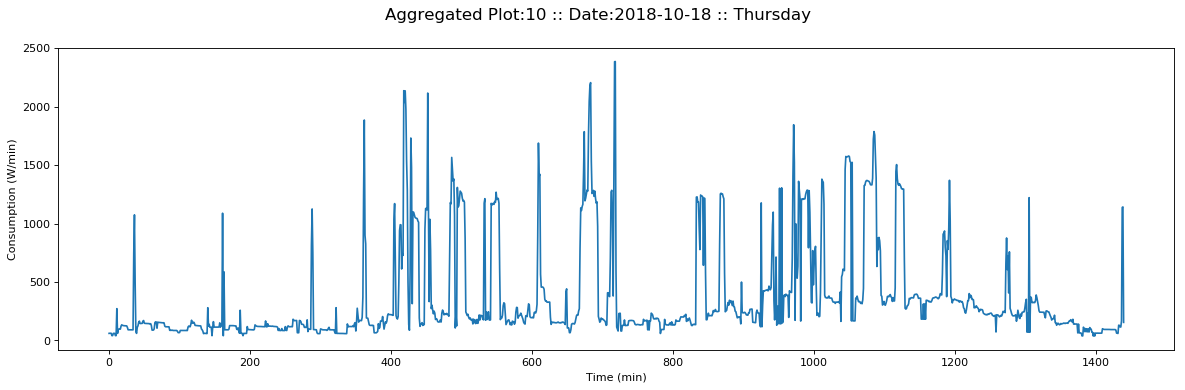

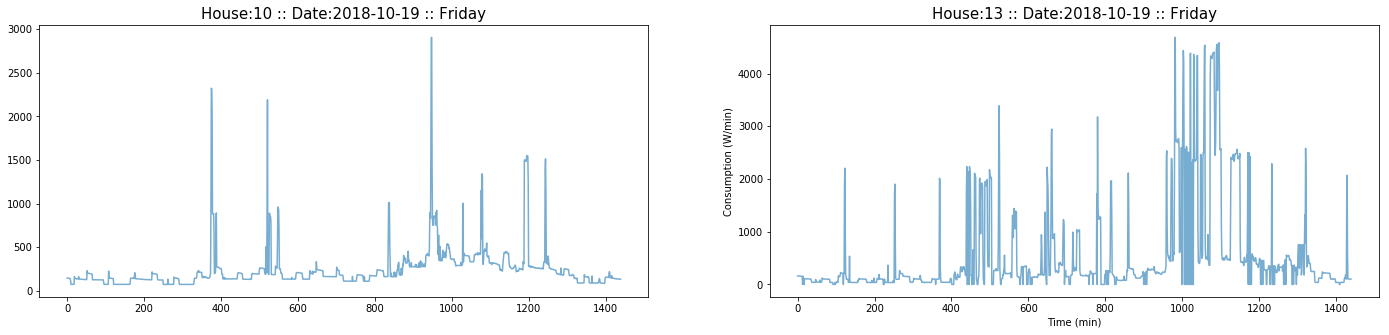

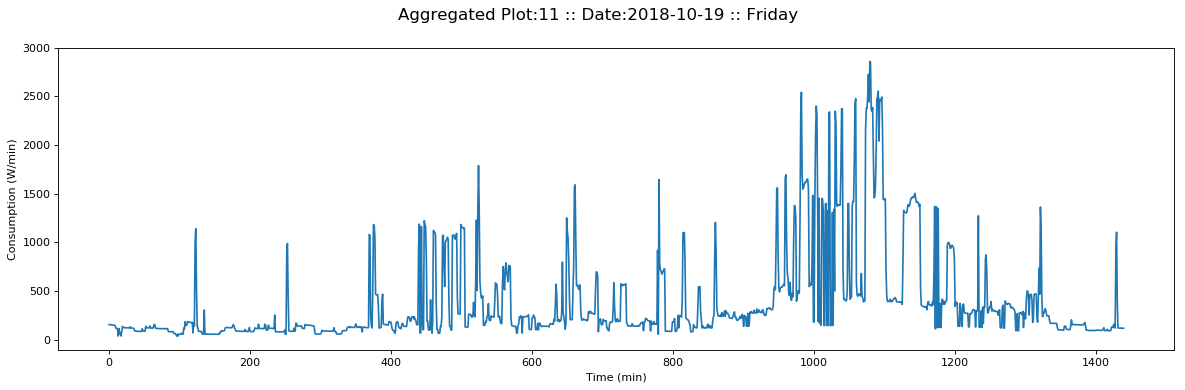

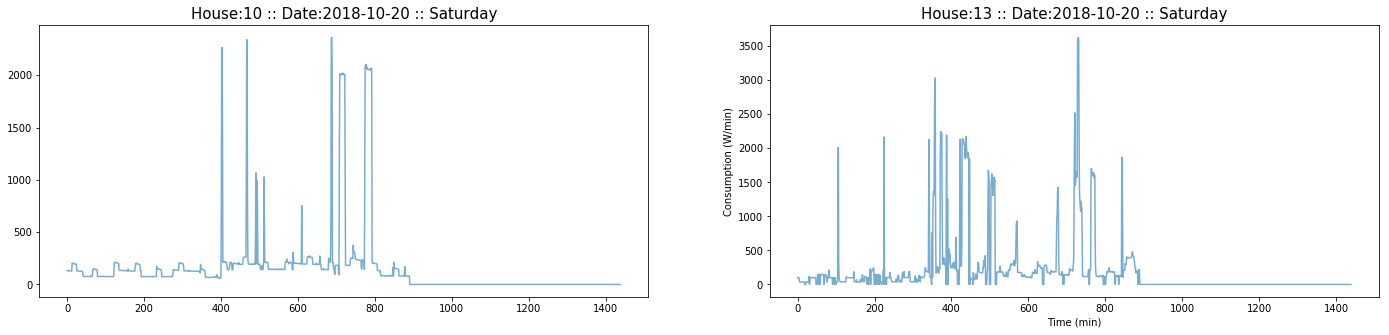

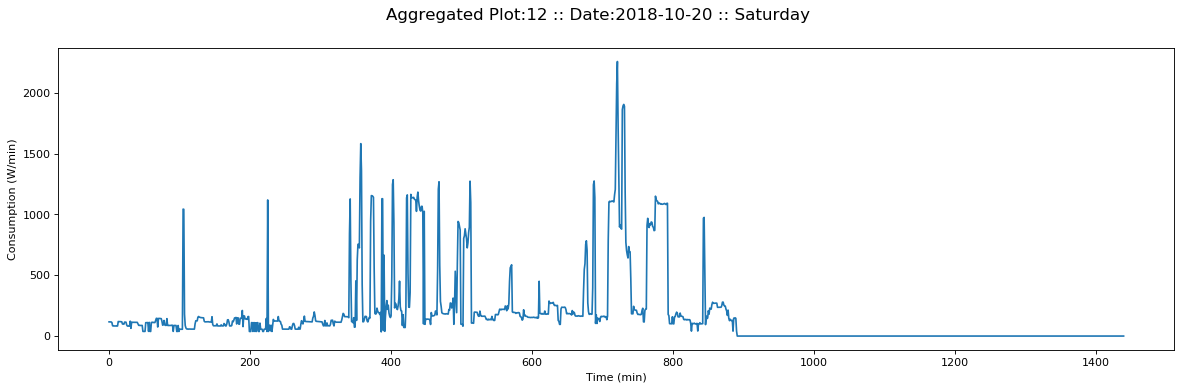

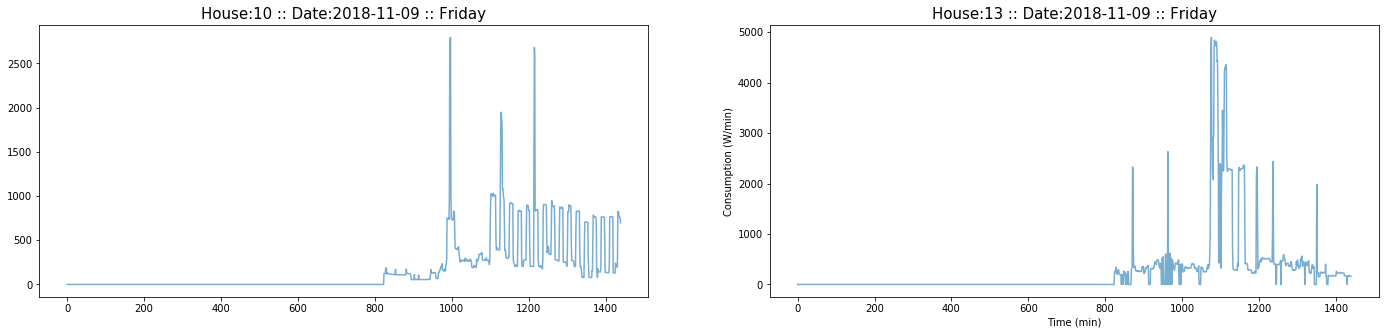

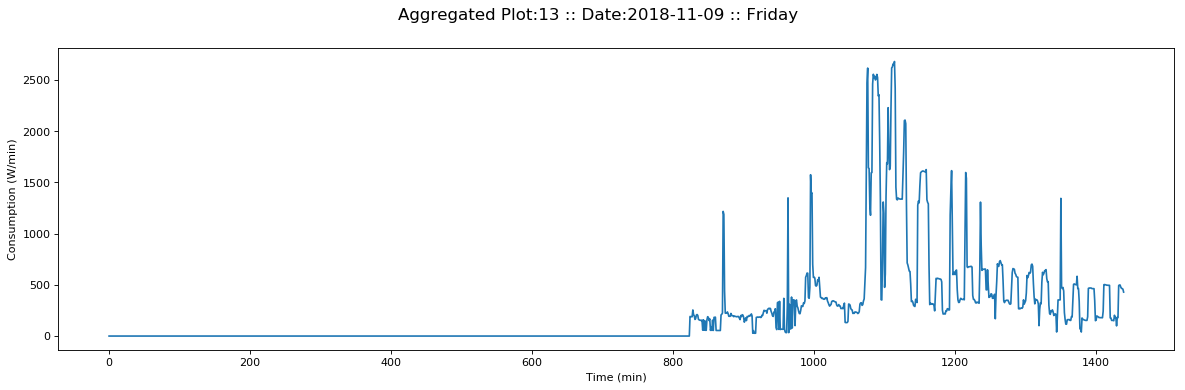

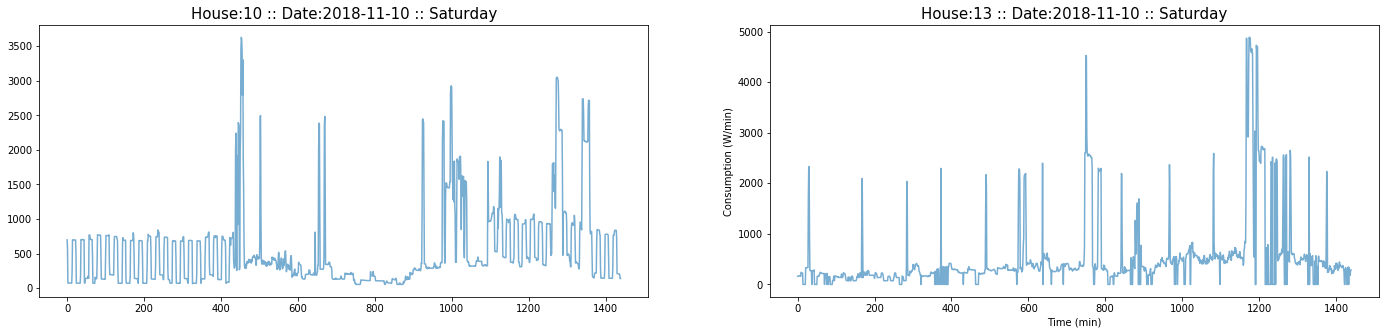

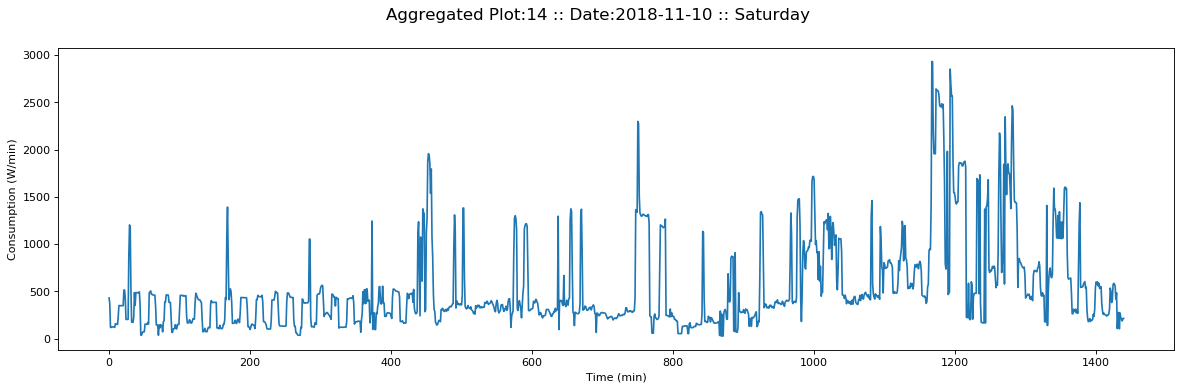

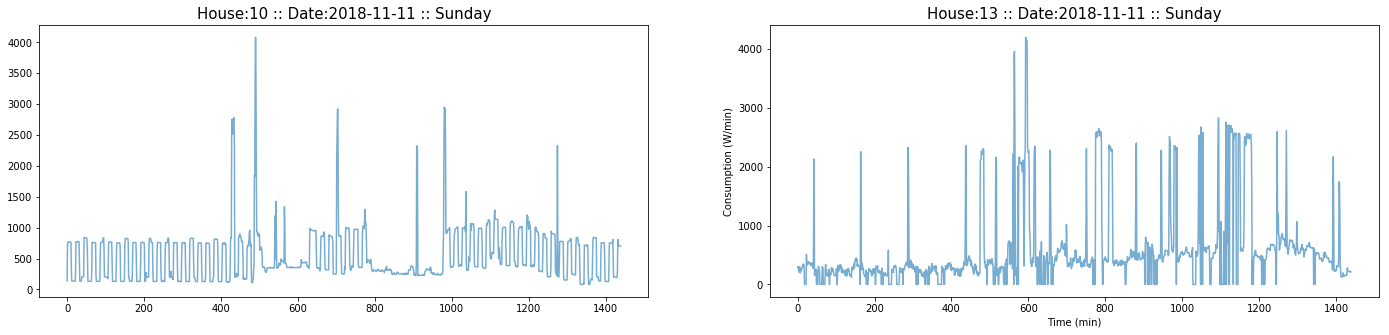

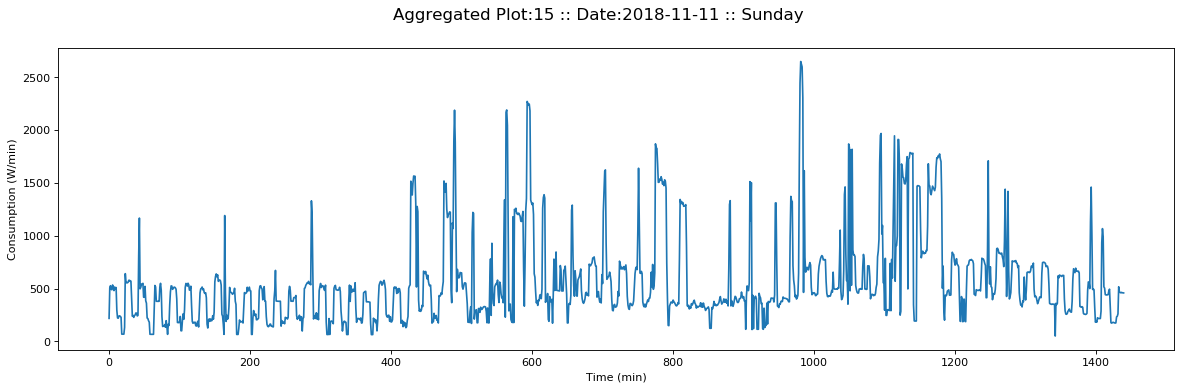

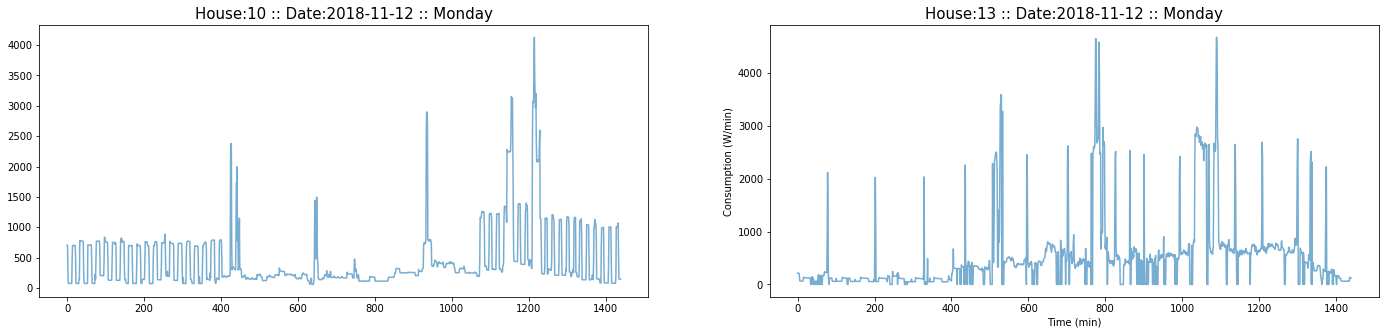

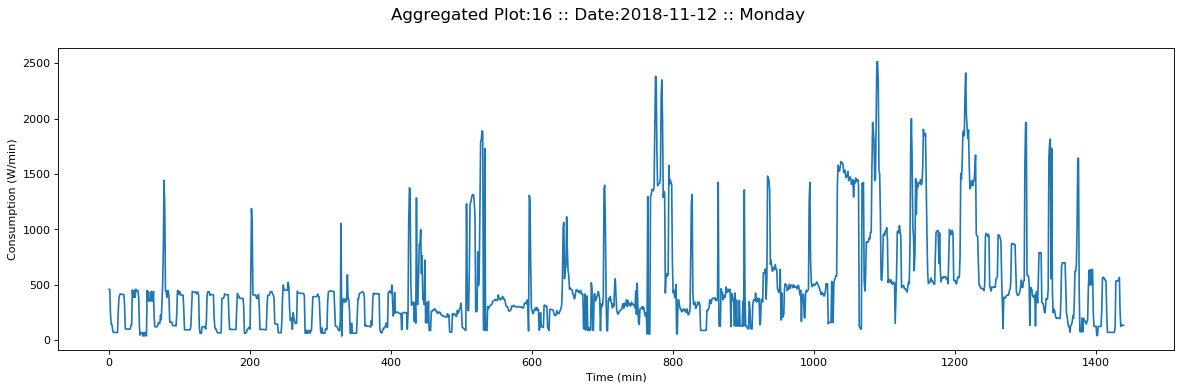

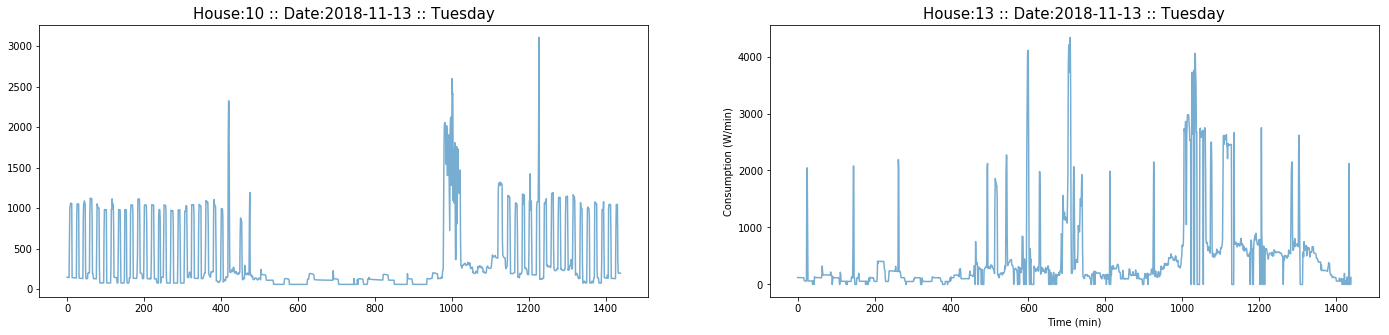

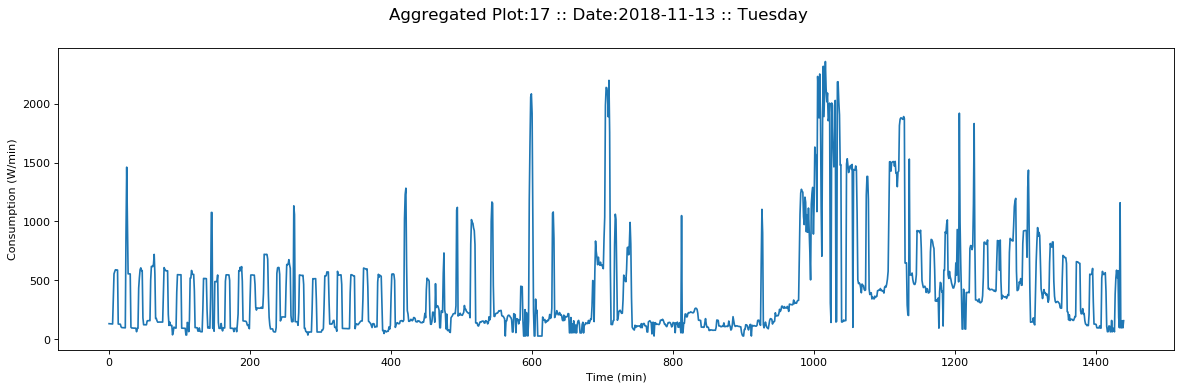

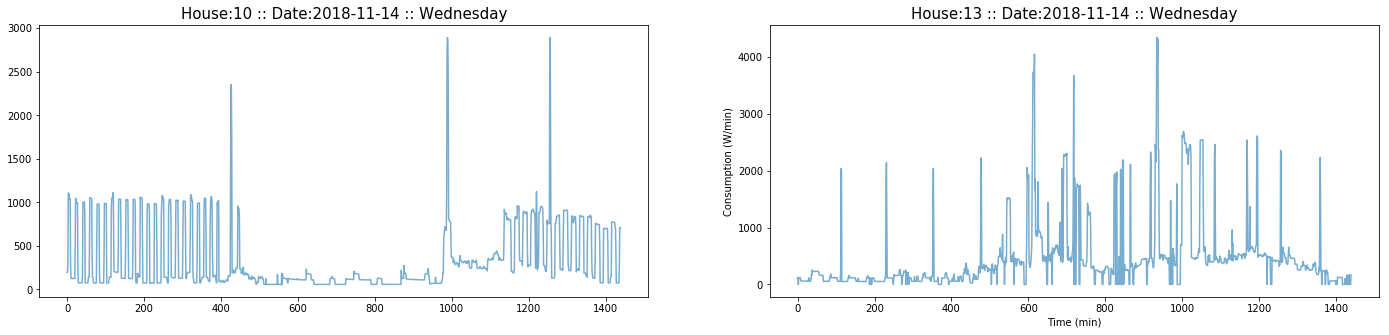

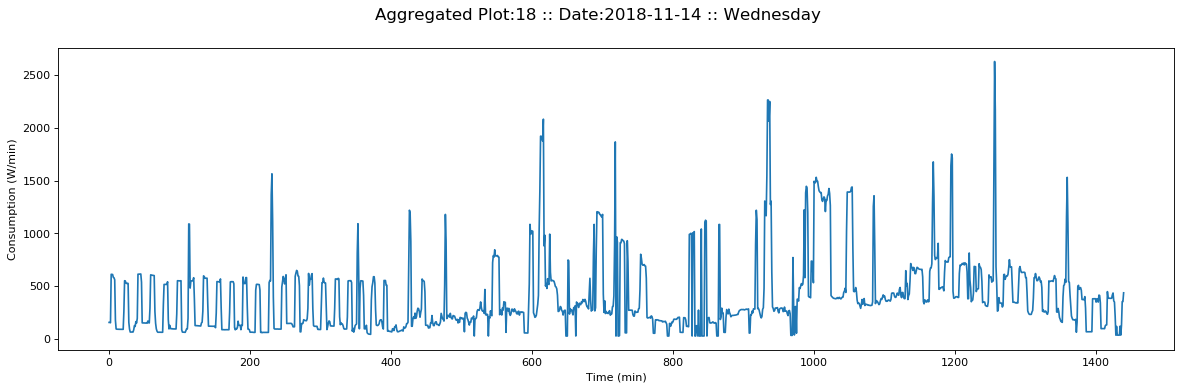

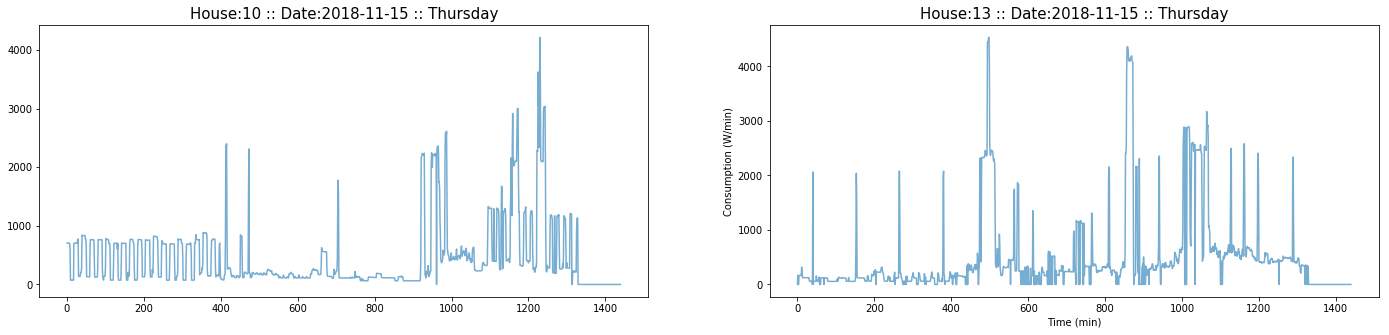

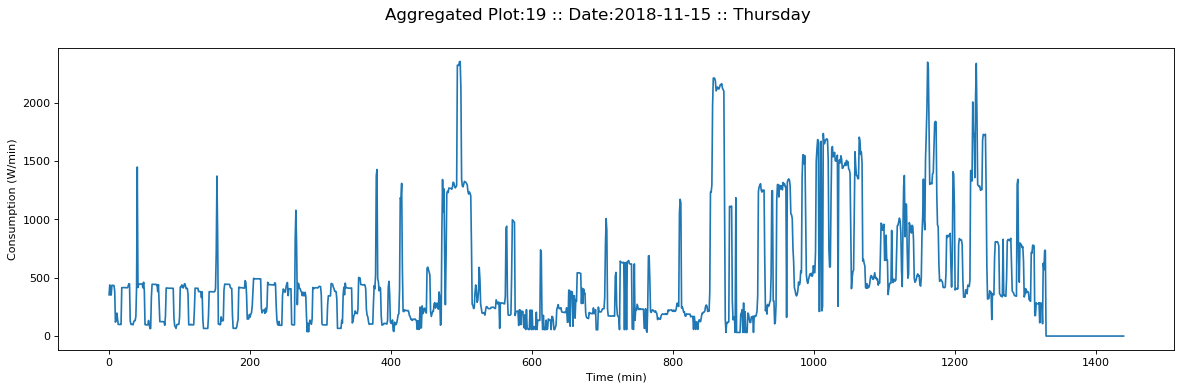

In [5]:
#get the mean aggregated data and compare with individual day
agg = aggregate(Matrices)

#set the data resolution to 15 min
res = 1 #resolution
agg = set_resolution(Date,agg,res)

#plot data
visual_data(Date,Matrices,agg,res)

### ----------------------------## Prepare balanced data for classification and perform classification ##-------------------------

In [6]:
#define the levels based on peak data
peak = agg.max()
#classify the data in 3 levels(l1 = Base load (<40% of peak), l2 = partially flexible(40 - 70 %), l3 = flexible (70% - peak))
l1 = 0.4*peak
l2 = 0.7*peak
l3 = peak
#get the random number in all three catagories (produce balanced data)
cl_val = create_label_dataset (l1,l2,l3)
#label the data
cl_lab = label_data(cl_val,l1,l2,l3)
#flatten the data for Neural Network
cl_val = cl_val.reshape(-1)
cl_lab = cl_lab.reshape(-1)

In [7]:
x_train,x_test,y_train,y_test = train_test_split(cl_val,cl_lab,test_size = 0.2,random_state = 4)
y_train = to_categorical(y_train, num_classes=4)

In [21]:
#model
def build_model(num_classes):
    model = Sequential()
    model.add(Dense(input_dim=1,units= 10000, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(512, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    model.summary()
    return model

model = build_model(4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10000)             20000     
_________________________________________________________________
dropout_8 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 40004     
Total params: 60,004
Trainable params: 60,004
Non-trainable params: 0
_________________________________________________________________


In [22]:
adam = Adam(lr = 0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer= adam, metrics = ['accuracy'] )
start = time.time()
checkpointer = ModelCheckpoint(filepath="C:/Users/20175377/OneDrive/SmartMeters/Model/C_simple1_nnA.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = model.fit( x_train, y_train,
                    batch_size=32, verbose=1, epochs=5,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Train on 160799 samples, validate on 79201 samples
Epoch 1/5
160799/160799 [==============================] - 87s 540us/step - loss: 10.7574 - acc: 0.3326 - val_loss: 10.7443 - val_acc: 0.3334
Epoch 2/5
160799/160799 [==============================] - 85s 530us/step - loss: 10.7564 - acc: 0.3327 - val_loss: 10.7443 - val_acc: 0.3334
Epoch 3/5
160799/160799 [==============================] - 83s 515us/step - loss: 10.7563 - acc: 0.3327 - val_loss: 10.7442 - val_acc: 0.3334
Epoch 4/5
160799/160799 [==============================] - 84s 520us/step - loss: 10.7563 - acc: 0.3327 - val_loss: 10.7442 - val_acc: 0.3334
Epoch 5/5
160799/160799 [==============================] - 82s 509us/step - loss: 10.7562 - acc: 0.3327 - val_loss: 10.7441 - val_acc: 0.3334
Finish trainning. Time:  421.8686554431915


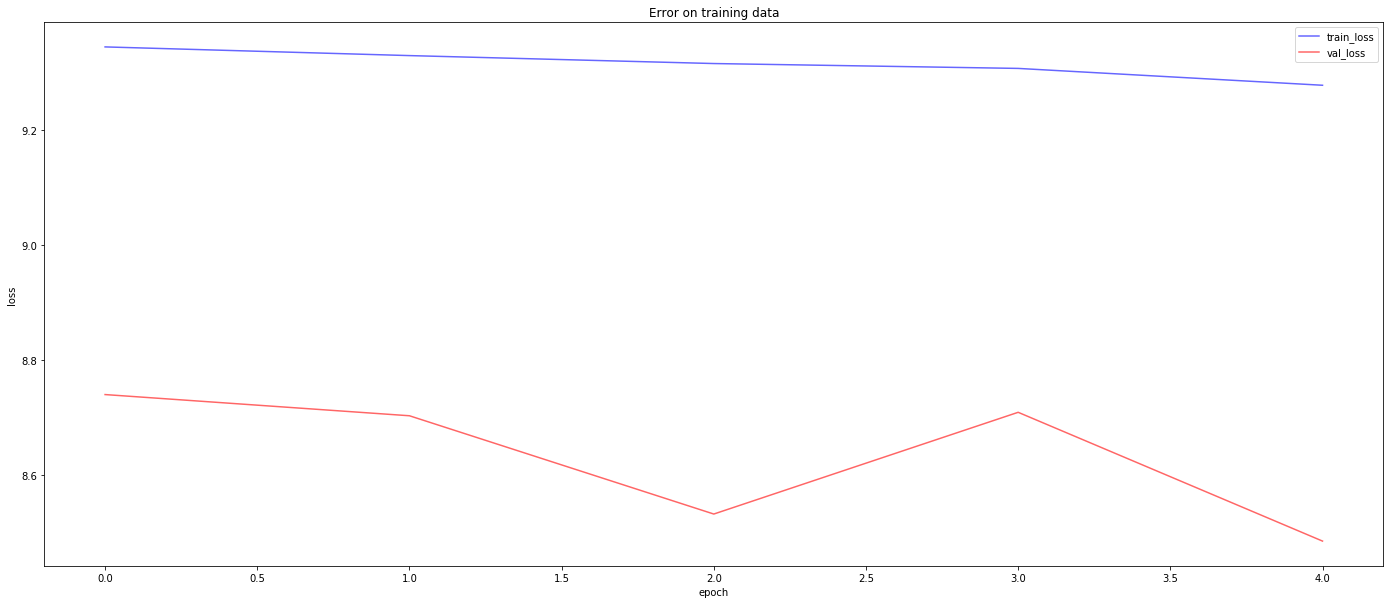

In [18]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
plot_losses(train_loss, val_loss)

### --------------------## Prediction model ##-------------------------

In [11]:
#normalize data (X - Xmin)/(Xmax - Xmin), Xmin = 0 , Xmax = C_max
b = agg/agg.max()

In [65]:
#flatten the data for neural network input
display(b.shape)
display(b)
b_flat = (b.T).reshape(-1,1)
display(b_flat.shape)
#display(b_flat)

(1440, 19)

array([[0.        , 0.0526415 , 0.04935851, ..., 0.04539733, 0.0536829 ,
        0.12061625],
       [0.        , 0.07119901, 0.04926379, ..., 0.04517792, 0.05367205,
        0.14939214],
       [0.        , 0.15702655, 0.04912171, ..., 0.0451083 , 0.05249137,
        0.12010205],
       ...,
       [0.04981459, 0.04839947, 0.03771675, ..., 0.05402583, 0.12072991,
        0.        ],
       [0.04949491, 0.04896908, 0.03411619, ..., 0.03334896, 0.12081326,
        0.        ],
       [0.05689442, 0.04894932, 0.04549313, ..., 0.05408503, 0.14930553,
        0.        ]])

(27360, 1)

In [67]:
#Divide the data set into train and test set
tr_d = len(Date) - 1 #We take all days-1 for training and one day for test
npt = tr_d*(1440)
Xtrain = b_flat[0:npt]
Ytrain = b_flat[1:(npt+1)]
Xtest  = b_flat[npt:-1]
Ytest  = b_flat[npt+1:]

In [68]:
display(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)

(25920, 1)

(25920, 1)

(1439, 1)

(1439, 1)

In [69]:
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

In [70]:
#model
def build_fc_model(layers):
    fc_model = Sequential()
    for i in range(len(layers)-1):
        fc_model.add( Dense(input_dim=layers[i], units= layers[i+1]) )
        if i < (len(layers) - 2):
            fc_model.add( Dropout(0.5) )
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu') )
    fc_model.summary()
    return fc_model
fc_model_1 = build_fc_model([1, 1024, 2048, 4096, 1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
activation_2 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              8392704   
__________

In [72]:
#adam = Adam(lr = 1e-5,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
fc_model_1.compile(loss='mean_squared_error', optimizer= 'adam', metrics = ['accuracy', metrics.mae] )
start = time.time()
checkpointer = ModelCheckpoint(filepath="C:/Users/20175377/OneDrive/SmartMeters/Model/simple1_nnA.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( Xtrain, Ytrain,
                    batch_size=512, verbose=1, epochs=50,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Train on 17366 samples, validate on 8554 samples
Epoch 1/50
17366/17366 [==============================] - 19s 1ms/step - loss: 0.0047 - acc: 0.1489 - mean_absolute_error: 0.0320 - val_loss: 0.0056 - val_acc: 0.0862 - val_mean_absolute_error: 0.0360
Epoch 2/50
17366/17366 [==============================] - 18s 1ms/step - loss: 0.0048 - acc: 0.1489 - mean_absolute_error: 0.0325 - val_loss: 0.0062 - val_acc: 0.0862 - val_mean_absolute_error: 0.0438
Epoch 3/50
17366/17366 [==============================] - 17s 992us/step - loss: 0.0047 - acc: 0.1489 - mean_absolute_error: 0.0326 - val_loss: 0.0060 - val_acc: 0.0862 - val_mean_absolute_error: 0.0408
Epoch 4/50
17366/17366 [==============================] - 19s 1ms/step - loss: 0.0048 - acc: 0.1489 - mean_absolute_error: 0.0331 - val_loss: 0.0056 - val_acc: 0.0862 - val_mean_absolute_error: 0.0385
Epoch 5/50
17366/17366 [==============================] - 18s 1ms/step - loss: 0.0047 - acc: 0.1489 - mean_absolute_error: 0.0318 - val_loss: 0.0

17366/17366 [==============================] - 17s 954us/step - loss: 0.0046 - acc: 0.1489 - mean_absolute_error: 0.0325 - val_loss: 0.0058 - val_acc: 0.0862 - val_mean_absolute_error: 0.0383
Epoch 42/50
17366/17366 [==============================] - 17s 962us/step - loss: 0.0046 - acc: 0.1489 - mean_absolute_error: 0.0324 - val_loss: 0.0058 - val_acc: 0.0862 - val_mean_absolute_error: 0.0432
Epoch 43/50
17366/17366 [==============================] - 17s 982us/step - loss: 0.0047 - acc: 0.1489 - mean_absolute_error: 0.0333 - val_loss: 0.0056 - val_acc: 0.0862 - val_mean_absolute_error: 0.0371
Epoch 44/50
17366/17366 [==============================] - 15s 887us/step - loss: 0.0047 - acc: 0.1489 - mean_absolute_error: 0.0329 - val_loss: 0.0058 - val_acc: 0.0862 - val_mean_absolute_error: 0.0372
Epoch 45/50
17366/17366 [==============================] - 15s 887us/step - loss: 0.0046 - acc: 0.1489 - mean_absolute_error: 0.0324 - val_loss: 0.0056 - val_acc: 0.0862 - val_mean_absolute_error:

In [73]:
fc_model_1 = load_model('C:/Users/20175377/OneDrive/SmartMeters/Model/simple1_nnA.hdf5')
pred_fc_1 = fc_model_1.predict(Xtest).reshape(-1)
mse_loss_fc_1 = mse_loss(pred_fc_1, Ytest)
mae_loss_fc_1 = mae_loss(pred_fc_1, Ytest)
print('Mean square error on test set: ', mse_loss_fc_1)
print('Mean absolute error on the test set: ', mae_loss_fc_1)

Mean square error on test set:  0.04888631667307311
Mean absolute error on the test set:  0.15865441952205603


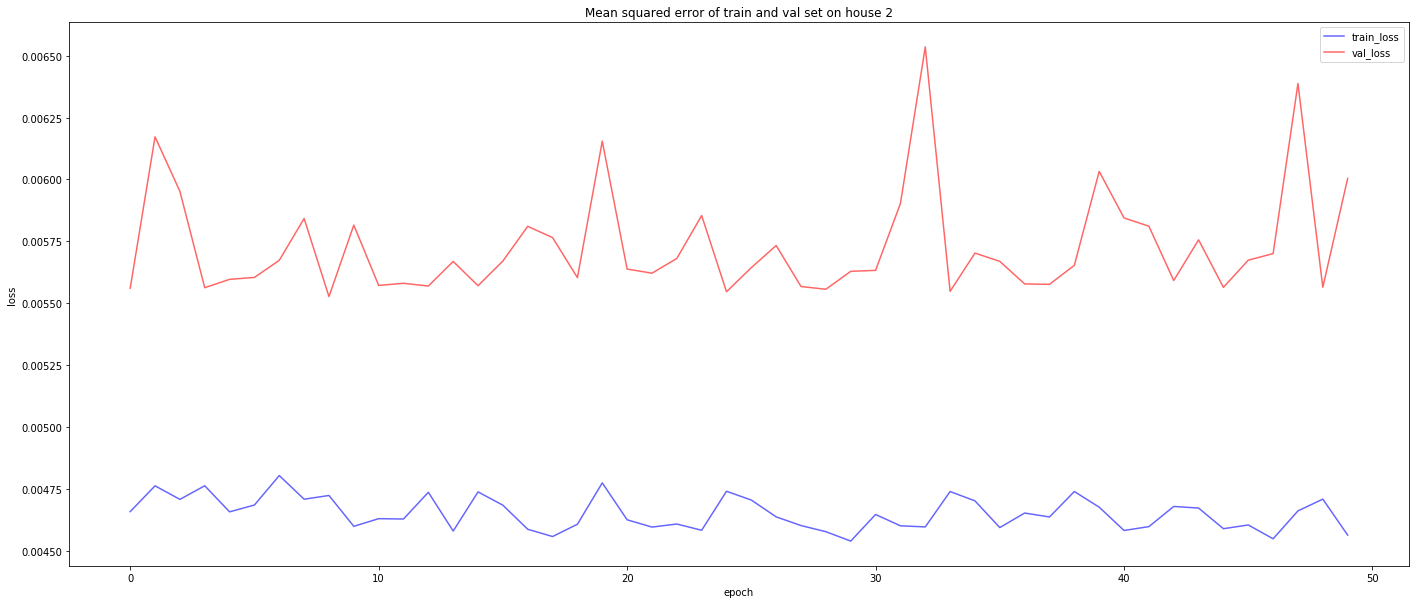

In [74]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 2')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [75]:
display(Ytest.shape,pred_fc_1.shape)
display(pd.DataFrame(np.array([(Ytest.reshape(-1)), (pred_fc_1)]).T))

(1439, 1)

(1439,)

,0,1
0,0.149392,0.129194
1,0.120102,0.157625
2,0.119893,0.128641
3,0.148187,0.128416
4,0.148109,0.156549
5,0.148066,0.156478
6,0.147381,0.156439
7,0.130475,0.155809
8,0.040636,0.139665
9,0.045658,0.053307


C:\Users\20175377\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


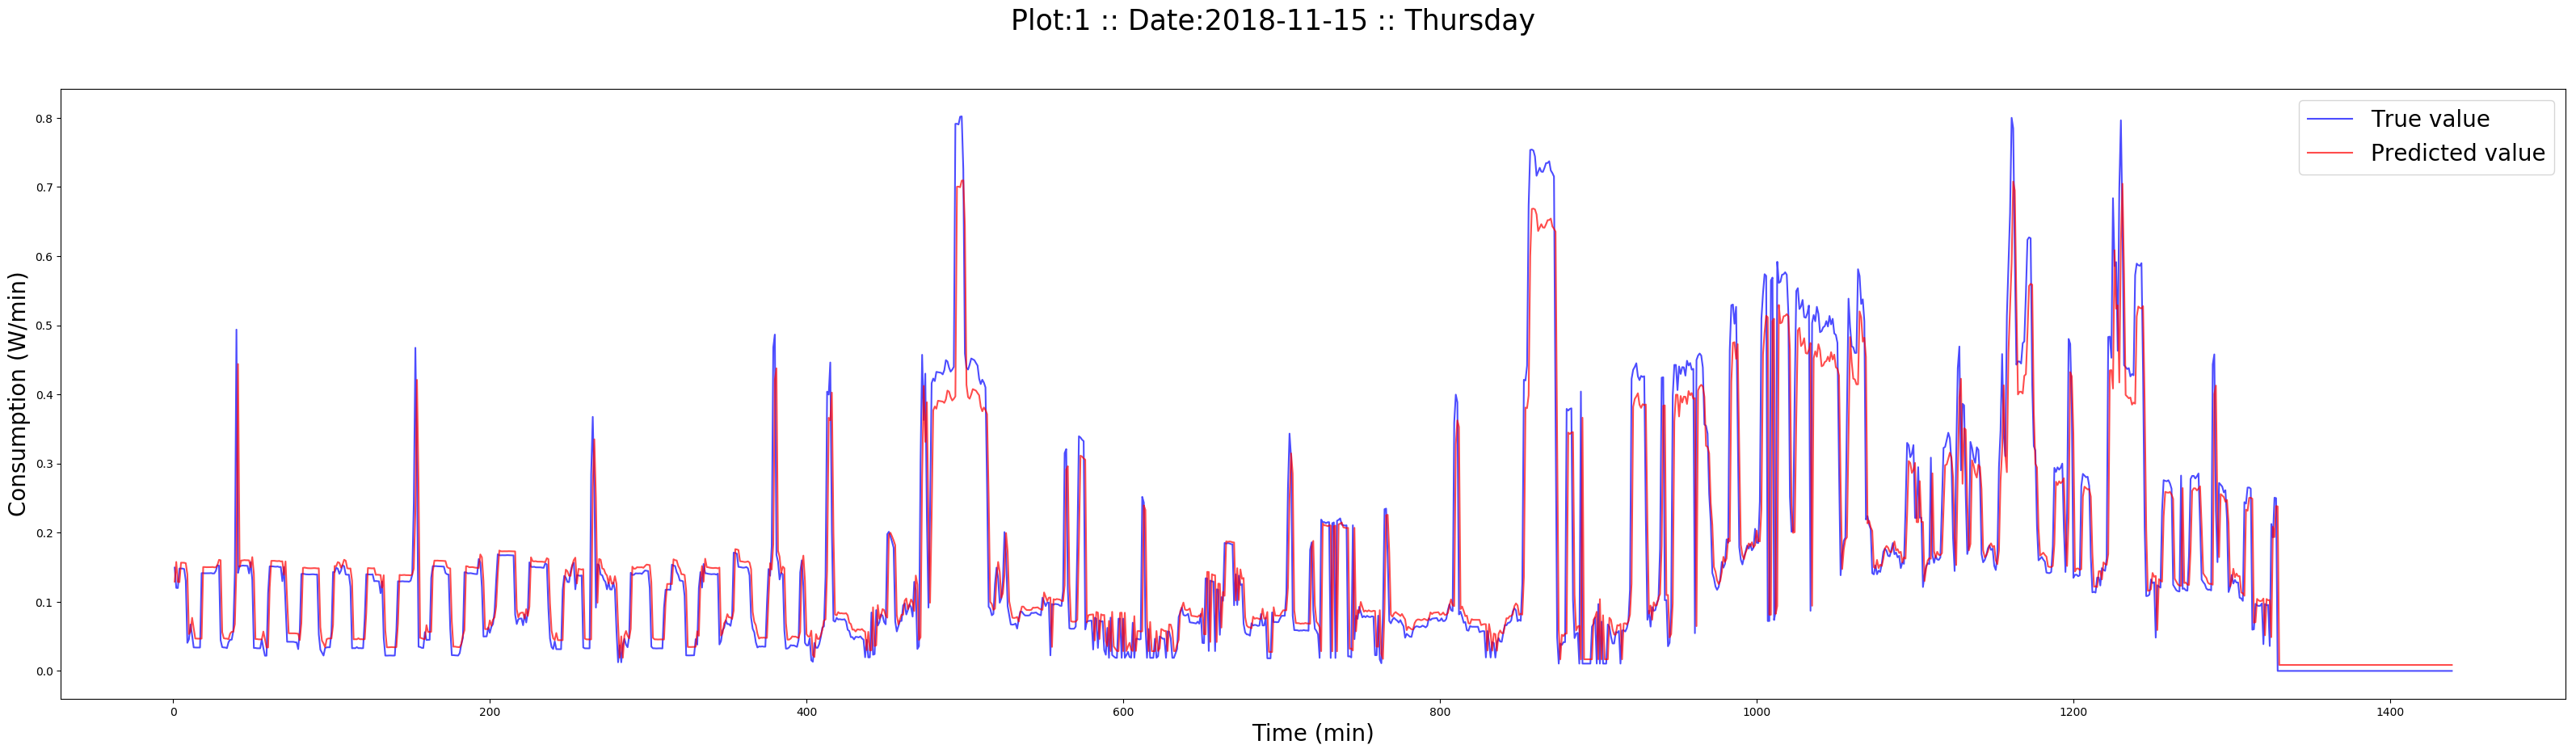

In [77]:
# Plot real and predicted values
fig, axes = plt.subplots(1,1,figsize=(40,10), dpi = 100 )
title = 'Plot:{0} :: Date:{1} :: {2}'.format(1,Date[-1], calendar.day_name[(datetime.datetime.strptime(Date[-1], '%Y-%m-%d')).weekday()])
plt.suptitle(title, fontsize = '25')
#fig.tight_layout()
#fig.subplots_adjust(top=0.95)
ind = np.linspace(1, len(Ytest), num=1+(len(Ytest)-1)/1) #np.linspace(z_start, z_stop, num=1+(z_stop-z_start)/step)
axes.plot(ind, Ytest.reshape(-1), color = 'blue', alpha = 0.7, label = 'True value')
axes.plot(ind, pred_fc_1, color = 'red', alpha = 0.7, label = 'Predicted value')
axes.legend(fontsize = '20')
plt.ylabel('Consumption (W/min)',fontsize = 20)
plt.xlabel('Time (min)',fontsize = 20)
plt.show()